In [29]:
import pandas as pd
import json

# Langkah 1: Membaca file JSONL secara manual dengan mengabaikan baris rusak
file_path = 'Electronics.jsonl'

# Membaca dataset JSONL dan mengabaikan baris rusak
data = []
with open(file_path, 'r') as file:
    for line in file:
        try:
            # Parsing JSON per baris
            data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Baris rusak diabaikan: {line.strip()}")  # Log baris yang rusak

# Konversi data bersih ke DataFrame
df = pd.DataFrame(data)

# Menyimpan data bersih ke file CSV untuk referensi
df.to_csv('Cleaned_Electronics_Data.csv', index=False)
print("Data berhasil dibersihkan dan disimpan ke 'Cleaned_Electronics_Data.csv'.")

# Langkah 2: Data Cleaning
# Hapus baris dengan kolom penting yang kosong
df = df.dropna(subset=['rating', 'asin', 'text'])

# Normalisasi tipe data
df['rating'] = df['rating'].astype(float)  # Pastikan kolom rating adalah float
df['helpful_vote'] = df['helpful_vote'].fillna(0).astype(int)  # Isi nilai kosong dengan 0, kemudian ubah ke int

# Konversi kolom kompleks (list/dict) menjadi string sementara
for column in df.columns:
    if df[column].apply(lambda x: isinstance(x, (list, dict))).any():
        df[column] = df[column].apply(lambda x: str(x))

# Hapus duplikasi
df = df.drop_duplicates()

# Menyimpan dataset yang telah dibersihkan ke file CSV
df.to_csv('Cleaned_And_Processed_Electronics.csv', index=False)

# Ringkasan dataset
print(f"Dataset setelah cleaning: {df.shape[0]} baris.")
print("Dataset bersih disimpan ke 'Cleaned_And_Processed_Electronics.csv'.")


Baris rusak diabaikan: {"rating": 2.0, "title": "Dont purchase", "text": "The two Amazon based products I've purchased, both are cheap, in price & quality. I have a small speaker, cheaper in price than this one that sounds better. At first, I thought this was going to sound good, due to size and reviews. No, mine doesn't sound clear. I'm not a hard core music fan who
Data berhasil dibersihkan dan disimpan ke 'Cleaned_Electronics_Data.csv'.
Dataset setelah cleaning: 67037 baris.
Dataset bersih disimpan ke 'Cleaned_And_Processed_Electronics.csv'.


In [32]:
# Menambahkan kolom popularitas (jumlah ulasan per produk)
df['popularity'] = df.groupby('asin')['asin'].transform('count')

# Menentukan threshold untuk head dan tail
rating_threshold = 4.0  # Rating minimum untuk head
helpful_vote_median = df['helpful_vote'].median()  # Median helpful vote untuk threshold
popularity_threshold = 10  # Popularitas minimum untuk head

# Menambahkan kolom kategori ('head' atau 'tail') untuk memastikan semua data terbagi
df['category'] = df.apply(
    lambda row: 'head' if (
        row['rating'] >= rating_threshold and
        row['helpful_vote'] >= helpful_vote_median and
        row['popularity'] >= popularity_threshold
    ) else 'tail', axis=1
)

# Memastikan tidak ada data yang tidak masuk kategori
assert df['category'].notnull().all(), "Terdapat data yang tidak masuk kategori head atau tail."

# Pisahkan dataset menjadi dua bagian
df_head = df[df['category'] == 'head']  # Semua data head
df_tail = df[df['category'] == 'tail']  # Semua data tail

# Simpan masing-masing kategori ke file terpisah
df_head.to_csv('head.csv', index=False)
df_tail.to_csv('tail.csv', index=False)

# Print ringkasan
print(f"Semua dataset telah terbagi menjadi dua bagian:")
print(f"Head disimpan ke 'head.csv': {df_head.shape[0]} baris.")
print(f"Tail disimpan ke 'tail.csv': {df_tail.shape[0]} baris.")


Semua dataset telah terbagi menjadi dua bagian:
Head disimpan ke 'head.csv': 4263 baris.
Tail disimpan ke 'tail.csv': 62774 baris.


In [34]:
from sklearn.utils import resample

# Resampling
# Oversampling tail (data kurang populer) agar seimbang dengan head
df_head_resampled = resample(df_head, replace=True, n_samples=max(len(df_head), len(df_tail)), random_state=42)
df_tail_resampled = resample(df_tail, replace=True, n_samples=max(len(df_head), len(df_tail)), random_state=42)

# Menggabungkan dataset head dan tail yang telah diresample
df_balanced = pd.concat([df_head_resampled, df_tail_resampled])

# Reweighting
# Tambahkan kolom bobot: Head diberi bobot lebih kecil, Tail diberi bobot lebih besar
df_balanced['weight'] = df_balanced['category'].apply(lambda x: 1.0 if x == 'head' else 2.0)

# Simpan dataset yang telah diresample dan reweighted ke file
df_balanced.to_csv('balanced_dataset.csv', index=False)

# Print ringkasan
print(f"Dataset setelah resampling dan reweighting:")
print(f"Head: {len(df_balanced[df_balanced['category'] == 'head'])} baris.")
print(f"Tail: {len(df_balanced[df_balanced['category'] == 'tail'])} baris.")
print("Dataset seimbang disimpan ke 'balanced_dataset.csv'.")


Dataset setelah resampling dan reweighting:
Head: 62774 baris.
Tail: 62774 baris.
Dataset seimbang disimpan ke 'balanced_dataset.csv'.


In [37]:
import numpy as np

# Pareto LT Ratio
def pareto_lt_ratio(df, popularity_col='popularity'):
    total_popularity = df[popularity_col].sum()
    df_sorted = df.sort_values(by=popularity_col, ascending=False)
    head_popularity = df_sorted.head(int(0.2 * len(df_sorted)))[popularity_col].sum()
    return head_popularity / total_popularity

# Imbalance Factor
def imbalance_factor(df, category_col='category'):
    head_count = len(df[df[category_col] == 'head'])
    tail_count = len(df[df[category_col] == 'tail'])
    return tail_count / head_count if head_count > 0 else np.inf

# Gini Coefficient
def gini_coefficient(df, popularity_col='popularity'):
    values = np.array(df[popularity_col])
    sorted_values = np.sort(values)
    cumulative_values = np.cumsum(sorted_values) / sorted_values.sum()
    cumulative_index = np.linspace(0, 1, len(cumulative_values))
    gini = 1 - 2 * np.trapz(cumulative_values, cumulative_index)
    return gini

# Evaluasi tingkat long-tailness
pareto_ratio = pareto_lt_ratio(df_balanced)
imbalance = imbalance_factor(df_balanced)
gini = gini_coefficient(df_balanced)

print(f"Pareto LT Ratio: {pareto_ratio:.4f}")
print(f"Imbalance Factor: {imbalance:.4f}")
print(f"Gini Coefficient: {gini:.4f}")


Pareto LT Ratio: 0.7750
Imbalance Factor: 1.0000
Gini Coefficient: 0.7303


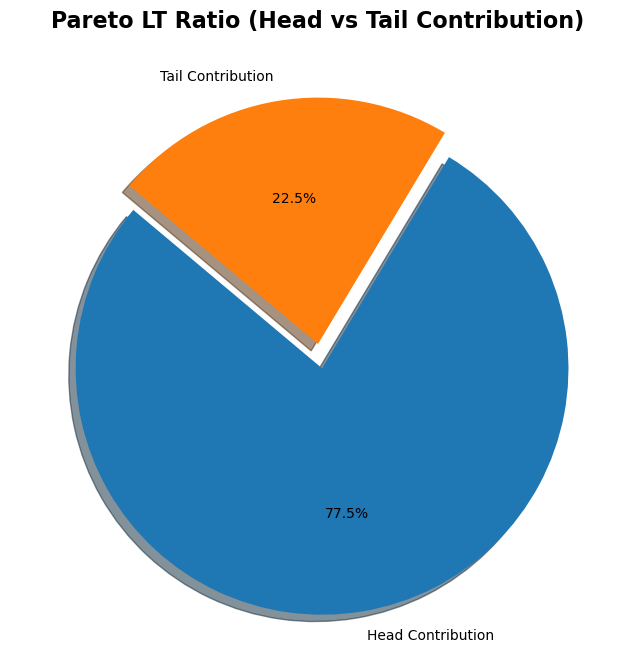

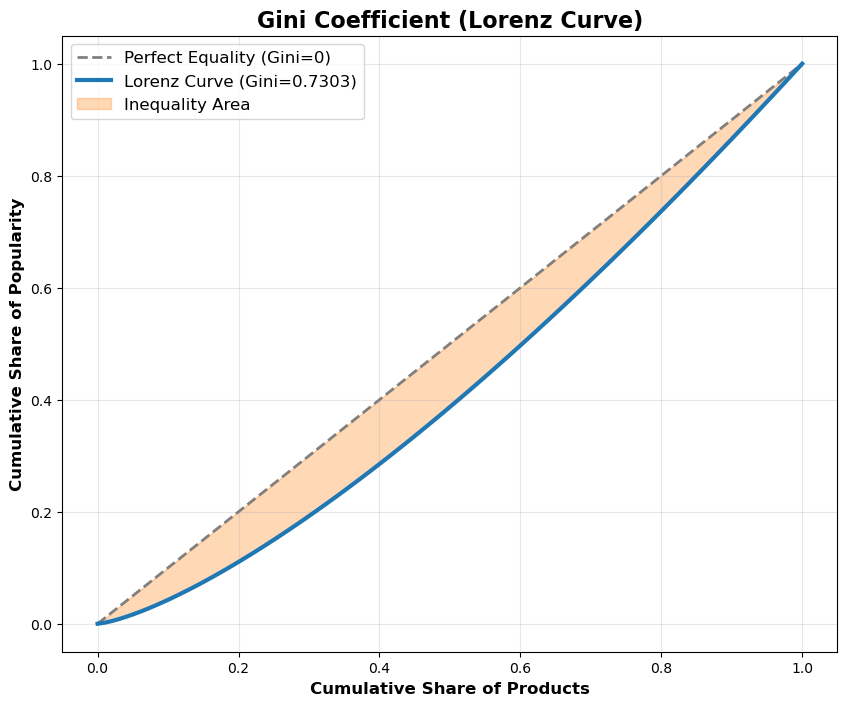

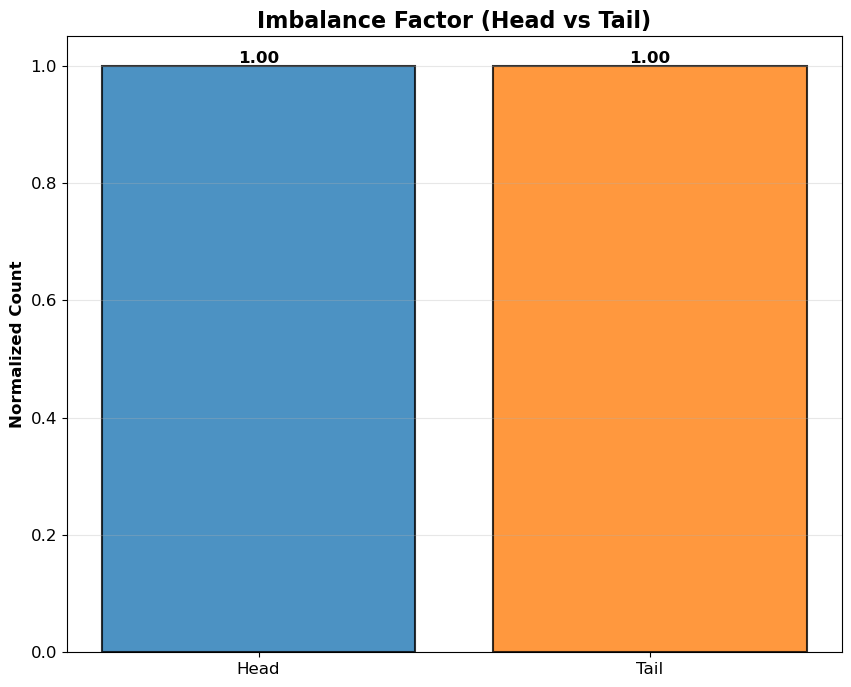

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Data dari hasil evaluasi
pareto_lt_ratio = 0.7750
imbalance_factor = 1.0000
gini_coefficient = 0.7303

# Warna untuk grafik
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Visualisasi Pareto LT Ratio
plt.figure(figsize=(10, 8))
labels = ['Head Contribution', 'Tail Contribution']
sizes = [pareto_lt_ratio, 1 - pareto_lt_ratio]
explode = (0.1, 0)  # Highlight Head Contribution
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors[:2], explode=explode, shadow=True)
plt.title('Pareto LT Ratio (Head vs Tail Contribution)', fontsize=16, fontweight='bold')
plt.show()

# Visualisasi Gini Coefficient (Distribusi Popularitas)
x = np.linspace(0, 1, 100)
perfect_equality = x
lorenz_curve = np.linspace(0, 1, 100) ** (1 / gini_coefficient)  # Simulasi lorenz berbasis Gini

plt.figure(figsize=(10, 8))
plt.plot(x, perfect_equality, label='Perfect Equality (Gini=0)', linestyle='--', color='grey', linewidth=2)
plt.plot(x, lorenz_curve, label=f'Lorenz Curve (Gini={gini_coefficient:.4f})', color=colors[0], linewidth=3)
plt.fill_between(x, lorenz_curve, perfect_equality, color=colors[1], alpha=0.3, label='Inequality Area')
plt.xlabel('Cumulative Share of Products', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Share of Popularity', fontsize=12, fontweight='bold')
plt.title('Gini Coefficient (Lorenz Curve)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Visualisasi Imbalance Factor
categories = ['Head', 'Tail']
counts = [1, imbalance_factor]
plt.figure(figsize=(10, 8))
bars = plt.bar(categories, counts, color=colors[:2], alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('Imbalance Factor (Head vs Tail)', fontsize=16, fontweight='bold')
plt.ylabel('Normalized Count', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.bar_label(bars, fmt='%.2f', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


In [50]:
# Menambahkan kolom popularitas (jumlah ulasan per produk)
df['popularity'] = df.groupby('asin')['asin'].transform('count')

# Menentukan threshold untuk head dan tail
popularity_threshold = 10  # Threshold ulasan untuk head
df['category'] = df['popularity'].apply(lambda x: 'head' if x >= popularity_threshold else 'tail')

# Membagi dataset ke dalam head dan tail
df_head = df[df['category'] == 'head']
df_tail = df[df['category'] == 'tail']

print(f"Jumlah produk head: {df_head['asin'].nunique()}")
print(f"Jumlah produk tail: {df_tail['asin'].nunique()}")


Jumlah produk head: 359
Jumlah produk tail: 32101


In [79]:
file_path = 'balanced_dataset.csv'  

df = pd.read_csv(file_path)

# Hitung jumlah pengguna unik dan item unik
num_users = df['user_id'].nunique()  # Jumlah unik pengguna
num_items = df['asin'].nunique()  # Jumlah unik item (produk)

# Hitung jumlah transaksi (ulasan)
num_transactions = len(df)

# Cetak hasil
print(f"Jumlah pengguna unik: {num_users}")
print(f"Jumlah item unik: {num_items}")
print(f"Jumlah transaksi (ulasan): {num_transactions}")


Jumlah pengguna unik: 8662
Jumlah item unik: 32460
Jumlah transaksi (ulasan): 125548


In [81]:
# Nilai dari dataset
num_users = 8662
num_items = 32460
num_transactions = 125548

# Hitung sparsity
sparsity_percentage = 100 - ((num_transactions / (num_users * num_items)) * 100)


print(f"Tingkat sparsity dataset: {sparsity_percentage:.2f}%")


Tingkat sparsity dataset: 99.96%


In [71]:
import pandas as pd

# Membaca dataset
file_path = 'balanced_dataset.csv'
df = pd.read_csv(file_path)

# **Sparsity Keseluruhan**
num_users = df['user_id'].nunique()
num_items = df['asin'].nunique()
num_transactions = len(df)

total_possible_interactions = num_users * num_items
overall_sparsity = 100 - ((num_transactions / total_possible_interactions) * 100)

# **Filter untuk Tail**
df_verified = df[df['verified_purchase'] == True]
df_verified = df_verified.copy()
df_verified['popularity'] = df_verified.groupby('asin')['asin'].transform('count')

popularity_threshold = 5  # Produk dengan ulasan kurang dari 5 dianggap tail
df_tail = df_verified[df_verified['popularity'] < popularity_threshold]

# **Sparsity Tail**
num_users_tail = df_tail['user_id'].nunique()
num_items_tail = df_tail['asin'].nunique()
num_transactions_tail = len(df_tail)

total_possible_interactions_tail = num_users_tail * num_items_tail
tail_sparsity = 100 - ((num_transactions_tail / total_possible_interactions_tail) * 100)

# Menampilkan hasil
print(f"Tingkat sparsity keseluruhan: {overall_sparsity:.2f}%")
print(f"Tingkat sparsity untuk tail: {tail_sparsity:.2f}%")

# Simpan subset tail ke file CSV (opsional)
df_tail.to_csv('tail_subset.csv', index=False)
print("Subset tail telah disimpan ke file 'tail_subset.csv'.")


Tingkat sparsity keseluruhan: 99.96%
Tingkat sparsity untuk tail: 99.98%
Subset tail telah disimpan ke file 'tail_subset.csv'.


In [83]:
# Menghitung Sparsity pada Head
# Filter data untuk head
popularity_threshold = 5  # Produk dengan ulasan kurang dari 5 dianggap tail, lebih dari itu adalah head
df_head = df_verified[df_verified['popularity'] >= popularity_threshold]

# Menghitung jumlah pengguna unik, item unik, dan transaksi pada head
num_users_head = df_head['user_id'].nunique()
num_items_head = df_head['asin'].nunique()
num_transactions_head = len(df_head)

# Menghitung sparsity untuk head
total_possible_interactions_head = num_users_head * num_items_head
head_sparsity = 100 - ((num_transactions_head / total_possible_interactions_head) * 100)

# Menampilkan hasil
print(f"Tingkat sparsity keseluruhan: {overall_sparsity:.2f}%")
print(f"Tingkat sparsity untuk tail: {tail_sparsity:.2f}%")
print(f"Tingkat sparsity untuk head: {head_sparsity:.2f}%")

# Simpan subset head ke file CSV (opsional)
df_head.to_csv('head_subset.csv', index=False)
print("Subset head telah disimpan ke file 'head_subset.csv'.")


Tingkat sparsity keseluruhan: 99.96%
Tingkat sparsity untuk tail: 99.98%
Tingkat sparsity untuk head: 98.93%
Subset head telah disimpan ke file 'head_subset.csv'.
